#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [114]:
# 모듈 로딩
import torch                                # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                       # 인공신경망 관련 모듈
import torch.nn.functional as F             # 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer             # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score # 성능지표 관련 모듈 - 추가 설치
from torchinfo import summary               # 모델 정보 관련 모듈 - 추가 설치

import pandas as pd                         # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [115]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [116]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE=pd.read_csv('../data/iris.csv',usecols=[0,1,2,3])
irisDF=pd.DataFrame(DATA_FILE)

irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 nn.Linear 

In [117]:
# 모델 설계
# 입력층의 입력값/피쳐 => sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => petal.width 1개
# 입력층 : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
# 은닉층 : 입력 10, 출력 은닉층에 존재하는 퍼셉트론 개수 5, AF ReLU
# 출력층 : 입력 5, 출력 타겟/라벨 개수 1 , AF None
model=nn.Sequential(nn.Linear(3,50),
                       nn.ReLU(),
                       nn.Linear(50,30),
                       nn.ReLU(),
                       nn.Linear(30,1))
                   

In [118]:
# 모델 구조 확인
print(model)
summary(model, input_size=(200000, 3))

Sequential(
  (0): Linear(in_features=3, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [200000, 1]               --
├─Linear: 1-1                            [200000, 50]              200
├─ReLU: 1-2                              [200000, 50]              --
├─Linear: 1-3                            [200000, 30]              1,530
├─ReLU: 1-4                              [200000, 30]              --
├─Linear: 1-5                            [200000, 1]               31
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
Total mult-adds (M): 352.20
Input size (MB): 2.40
Forward/backward pass size (MB): 129.60
Params size (MB): 0.01
Estimated Total Size (MB): 132.01

In [119]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579],
        [ 0.1613,  0.5476,  0.3811],
        [-0.5260, -0.5489, -0.2785],
        [ 0.5070, -0.0962,  0.2471],
        [-0.2683,  0.5665, -0.2443],
        [ 0.4330,  0.0068, -0.3042],
        [ 0.2968, -0.3065,  0.1698],
        [-0.1667, -0.0633, -0.5551],
        [-0.2753,  0.3133, -0.1403],
        [ 0.5751,  0.4628, -0.0270],
        [-0.3854,  0.3516,  0.1792],
        [-0.3732,  0.3750,  0.3505],
        [ 0.5120, -0.3236, -0.0950],
        [-0.0112,  0.0843, -0.4382],
        [-0.4097,  0.3141, -0.1354],
        [ 0.2820,  0.0329,  0.1896],
        [ 0.1270,  0.2099,  0.2862],
     

[3] 최적화 인스턴스 준비

In [120]:
# 모델의 가중치와 절편을 최적화 => 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 => 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [121]:
irisDF.columns[:-1]

Index(['sepal.length', 'sepal.width', 'petal.length'], dtype='object')

In [122]:
# 피쳐와 타겟 분리
featureDF=irisDF[irisDF.columns[:-1]]
targetDF=irisDF[['petal.width']]
print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [123]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureDF, targetDF, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

TRAIN (96, 3), TEST (30, 3), VAL (24, 3)
TRAIN (96, 1), TEST (30, 1), VAL (24, 1)


- [4-2] 학습진행
    * 학습횟수 결정 => 에포크 설정
    * 배치크기 결정
    * 배치개수 계산

In [124]:
EPOCH=100                                                       # 처음~끝까지 공부하는 횟수
DP_SIZE=12                                                    # 1에포크에서 한 번 학습 할 분량 크기
DP_CNT=X_train.shape[0]//DP_SIZE                              # 1에포크에서 총 학습 횟수이자 업데이트 횟수

print(f'EPOCH: {EPOCH}, DP_SIZE: {DP_SIZE}, DP_CNT: {DP_CNT}')

EPOCH: 100, DP_SIZE: 12, DP_CNT: 8


In [125]:
# 테스트/검증 함수
# => 가중치, 절편 업데이트 X, 최적화 미진행
# => 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testDF, targetDF, kind='Val'):
    # Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)
    
    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 : forward
        pre_y=model(testTS)

        # (2) 오차계산 : 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        # (3) 성능평가 - R2
        r2=R2Score()(pre_y, targetTS)

        # (4) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}, R2 : {r2}')
    
    return loss, r2

In [126]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <= [train, val]
    loss_history=[[],[]]
    r2_history=[[],[]]
    
    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        ds_loss, ds_r2=0, 0

        # 배치크기 만큼 학습 진행
        for i in range(DP_CNT):
            start=i*DP_SIZE
            end=start + DP_SIZE
            print(start, end)
            # DP_SIZE 크기만큼만 데이터 추출해서 Tensor화 진행
            DSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            DSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(DSX_train.shape, DSX_train.device, DSX_train.dtype)
            # print(DSy_train.shape, DSy_train.device, DSy_train.dtype)

            # (1) 학습진행 : forward
            pre_y=model(DSX_train)
            # print(f'pre_y.shape : {pre_y.shape}')

            # (2) 오차계산 : 손실함수
            loss=F.mse_loss(pre_y, DSy_train)
            ds_loss += loss.item()
            ds_r2 += R2Score()(pre_y, DSy_train).item()

            # (3) 최적화 : 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
            
        # (4) 검증 : 모델이 제대로 만들어 지는지 검사용
        val_loss, val_r2=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(ds_loss/DP_CNT)
        r2_history[0].append(ds_r2/DP_CNT)

        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n-TRAIN LOSS : {loss_history[0][-1]} R2 : {r2_history[0][-1]}')
        print(f'-VALID LOSS : {loss_history[1][-1]} R2 : {r2_history[1][-1]}')
        
    return loss_history, r2_history

In [127]:
# 모델 학습 진행
loss, r2=training(X_train, y_train, X_val, y_val)

0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[Val] LOSS : 1.5711978673934937, R2 : -2.764756202697754
[0/100]
-TRAIN LOSS : 14.527392819523811 R2 : -21.821533054113388
-VALID LOSS : 1.5711978673934937 R2 : -2.764756202697754
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[Val] LOSS : 0.7309722900390625, R2 : -0.7514868974685669
[1/100]
-TRAIN LOSS : 1.224500272423029 R2 : -1.064141646027565
-VALID LOSS : 0.7309722900390625 R2 : -0.7514868974685669
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[Val] LOSS : 0.08642277121543884, R2 : 0.7929219007492065
[2/100]
-TRAIN LOSS : 0.43255666084587574 R2 : 0.29043734073638916
-VALID LOSS : 0.08642277121543884 R2 : 0.7929219007492065
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[Val] LOSS : 0.05174844339489937, R2 : 0.876005232334137
[3/100]
-TRAIN LOSS : 0.11140783922746778 R2 : 0.811126321554184
-VALID LOSS : 0.05174844339489937 R2 : 0.876005232334137
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[Val] LOSS : 0.08655818551778793, R2 : 0.79

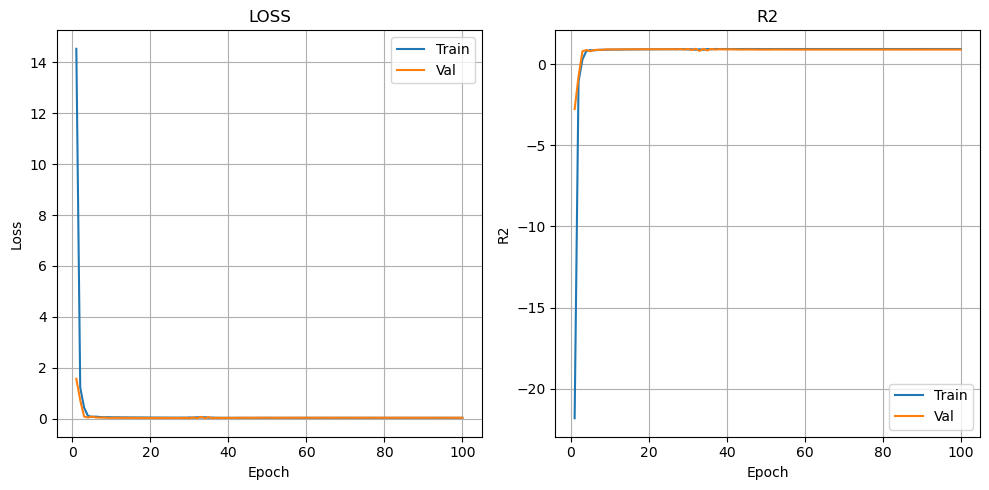

In [128]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,THRESHOLD+1),loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1,THRESHOLD+1),loss[1][:THRESHOLD], label='Val')
axes[0].set_title('LOSS')
axes[0].grid()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(1,THRESHOLD+1),r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1,THRESHOLD+1),r2[1][:THRESHOLD], label='Val')
axes[1].set_title('R2')
axes[1].grid()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2')
axes[1].legend()

plt.tight_layout()
plt.show()